# Filtrando dígitos 1 e 5

In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [31]:
train_redu = pd.read_csv("dataset_digits/train_redu.csv")
test_redu  = pd.read_csv("dataset_digits/test_redu.csv")

print("Train shape:", train_redu.shape)
print("Test shape:", test_redu.shape)
print(train_redu.head())

Train shape: (2186, 3)
Test shape: (1115, 3)
   label  intensidade   simetria
0      0    145.43529  148.57256
1      0    118.57647  137.11372
2      0    127.60000  134.04706
3      0    138.04706  151.00392
4      0    146.21568  122.50196


In [32]:
train1x5 = train_redu[train_redu["label"].isin([1, 5])].copy()
test1x5  = test_redu[test_redu["label"].isin([1, 5])].copy()

# Criação da variável-alvo y (+1 para dígito 1 e -1 para dígito 5)
train1x5["y"] = train1x5["label"].apply(lambda x: 1 if x == 1 else -1)
test1x5["y"]  = test1x5["label"].apply(lambda x: 1 if x == 1 else -1)

In [ ]:
X_train_1x5 = train1x5[["intensidade", "simetria"]].values.astype(float)
y_train = train1x5["y"].values.astype(int)

X_test_1x5 = test1x5[["intensidade", "simetria"]].values.astype(float)
y_test = test1x5["y"].values.astype(int)

# Escalonamento dos dados (0 a 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_1x5)
X_test  = scaler.transform(X_test_1x5)

print("\n--- Verificação das dimensões ---")
print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


--- Verificação das dimensões ---
Tamanho treino: (1184, 2)
Tamanho teste: (583, 2)


# Treinando modelos

## Perceptron

In [21]:
class PocketPLA:
    def __init__(self):
        self.w = None

    def get_w(self):
        return self.w

    def execute(self, X, y, max_iter=1000):
        # Adiciona bias internamente
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

        # Inicializa w como vetor de zeros
        self.w = np.zeros(X_bias.shape[1])

        # Armazena o melhor w (pocket) e o menor erro
        pocket_w = self.w.copy()
        best_error = self.errorIN(X_bias, y)

        for _ in range(max_iter):
            for i in range(len(y)):
                if np.sign(np.dot(self.w, X_bias[i])) != y[i]:
                    # Atualiza w com erro atual
                    self.w += y[i] * X_bias[i]

                    # Calcula erro com novo w
                    current_error = self.errorIN(X_bias, y)

                    # Se for melhor, guarda no pocket
                    if current_error < best_error:
                        pocket_w = self.w.copy()
                        best_error = current_error
                    break  # volta ao início do loop principal

        # Ao final, define o melhor w encontrado
        self.w = pocket_w
    
    def getOriginalY(self, originalX):
        """Calcula Y original da fronteira de decisão (para plot 2D)."""
        return (-self.w[0] - self.w[1]*originalX) / self.w[2]

    def h(self, x):
        # Adiciona bias automaticamente ao vetor de entrada
        x_bias = np.insert(x, 0, 1)  # insere o 1 no início
        return np.sign(np.dot(self.w, x_bias))
    
    def predict(self, X):
        """Predição em lote (usada na avaliação)."""
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        return np.sign(X_bias @ self.w)
    
    def errorIN(self, X_bias, y):
        error = 0
        for i in range(len(y)):
            if np.sign(np.dot(self.w, X_bias[i])) != y[i]:
                error += 1
        return error

In [34]:
# === Treina o modelo PocketPLA ===
perceptron = PocketPLA()
perceptron.execute(X_train, y_train)

print("\n--- Vetor de pesos treinado ---")
print(perceptron.w)

# === Predição no conjunto de teste ===
y_pred = np.array([perceptron.h(x) for x in X_test])

print("\n--- Predições no conjunto de teste ---")
print(y_pred[:20])


--- Vetor de pesos treinado ---
[ 1.         -1.44433724 -1.10248698]

--- Predições no conjunto de teste ---
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Regressão Linear

In [23]:
class LinearRegression:
    def __init__(self):
        self.w = None

    def execute(self, _X, _y, show=False):
        X0 = np.asarray(_X, dtype=float)
        y = np.asarray(_y, dtype=float).ravel()

        # Garante formato 2D
        if X0.ndim == 1:
            X0 = X0.reshape(-1, 1)

        # Matriz de projeto
        X = np.c_[np.ones((X0.shape[0], 1)), X0]

        if show:
            print("X =\n", X)
            print("y =\n", y)

        # Solução via pseudo-inversa (SVD internamente)
        self.w = np.linalg.pinv(X) @ y

        if show:
            print(f"W =\n{self.w}")

    def predict(self, _x, class_output=False):
        x0 = np.asarray(_x, dtype=float)
        if x0.ndim == 1:
            x0 = x0.reshape(1, -1)

        X = np.c_[np.ones((x0.shape[0], 1)), x0]
        y_pred = X @ self.w

        if class_output:
            y_class = np.sign(y_pred)
            y_class[y_class == 0] = 1
            return y_class

        return y_pred

    def get_w(self):
        return self.w

In [35]:
print("\n=== Treinando Regressão Linear ===")
linreg = LinearRegression()
linreg.execute(X_train, y_train)

print("--- Vetor de pesos (Regressão Linear) ---")
print(linreg.get_w())

print("\nPredições (valores contínuos):", linreg.predict(X_test)[:10])
print("Predições (classe):", linreg.predict(X_test, class_output=True)[:10])


=== Treinando Regressão Linear ===
--- Vetor de pesos (Regressão Linear) ---
[ 1.54070957 -1.37154157 -1.76466441]

Predições (valores contínuos): [1.11040128 0.82239142 1.21178615 0.9051132  0.97139312 1.11508664
 0.72707648 0.6534267  1.36058649 1.2074245 ]
Predições (classe): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Regressão Logística

In [25]:
class RegressaoLogistica:
    def __init__(self, eta=0.01, tmax=5000, lambda_=0.01):
        self.eta = eta
        self.tmax = tmax
        self.lambda_ = lambda_
        self.w = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.where(np.array(y) <= 0, -1, 1)

        X = np.c_[np.ones((X.shape[0], 1)), X]
        n_amostras, n_features = X.shape
        self.w = np.zeros(n_features)

        for _ in range(self.tmax):
            z = X @ self.w
            grad = -(1/n_amostras) * (X.T @ (y / (1 + np.exp(y * z))))
            grad[1:] += self.lambda_ * self.w[1:]
            self.w -= self.eta * grad

    def predict_prob(self, X):
        X = np.array(X)
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return self.sigmoid(X @ self.w)

    def predict(self, X):
        X = np.array(X)
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return np.sign(X @ self.w)

    def get_w(self):
        return self.w

In [36]:
print("\n=== Treinando Regressão Logística ===")
logreg = RegressaoLogistica(eta=0.1, tmax=5000, lambda_=0.01)
logreg.fit(X_train, y_train)
print("--- Vetor de pesos (Regressão Logística) ---")
print(logreg.get_w())
print("Predições (classe):", logreg.predict(X_test)[:10])
print("Probabilidades (sigmoid):", logreg.predict_prob(X_test)[:10])


=== Treinando Regressão Logística ===
--- Vetor de pesos (Regressão Logística) ---
[ 3.3208915  -3.2816977  -3.47746871]
Predições (classe): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Probabilidades (sigmoid): [0.91775504 0.86346748 0.93497744 0.88232557 0.88989013 0.91579963
 0.83661439 0.81325319 0.94927777 0.93386676]


# Avaliando modelos de predição

In [38]:
def avaliar_modelo(nome, modelo, X_val, y_val, X_te, y_te):
    yv = modelo.predict(X_val)
    yt = modelo.predict(X_te)

    # Se o modelo retornar valores contínuos, converter para classes ±1
    if np.any((yv != -1) & (yv != 1)):
        yv = np.sign(yv)
        yv[yv == 0] = 1  # tratar o caso raro de 0
    if np.any((yt != -1) & (yt != 1)):
        yt = np.sign(yt)
        yt[yt == 0] = 1

    print(f"\n=== {nome} | Treinamento ===")
    print(confusion_matrix(y_val, yv, labels=[-1, 1]))
    print(classification_report(y_val, yv, labels=[-1, 1], target_names=["Dígito 5 (-1)", "Dígito 1 (+1)"]))
    print("Acurácia (val): {:.2f}%".format(100*accuracy_score(y_val, yv)))

    print(f"\n=== {nome} | Teste ===")
    print(confusion_matrix(y_te, yt, labels=[-1, 1]))
    print(classification_report(y_te, yt, labels=[-1, 1],target_names=["Dígito 5 (-1)", "Dígito 1 (+1)"]))
    print("Acurácia (test): {:.2f}%".format(100*accuracy_score(y_te, yt)))

In [39]:
avaliar_modelo("Perceptron", perceptron, X_train, y_train, X_test, y_test)


=== Perceptron | Treinamento ===
[[576   0]
 [  0 608]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       576
Dígito 1 (+1)       1.00      1.00      1.00       608

     accuracy                           1.00      1184
    macro avg       1.00      1.00      1.00      1184
 weighted avg       1.00      1.00      1.00      1184

Acurácia (val): 100.00%

=== Perceptron | Teste ===
[[291   0]
 [  0 292]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       291
Dígito 1 (+1)       1.00      1.00      1.00       292

     accuracy                           1.00       583
    macro avg       1.00      1.00      1.00       583
 weighted avg       1.00      1.00      1.00       583

Acurácia (test): 100.00%


In [41]:
avaliar_modelo("Regressão Linear", linreg, X_train, y_train, X_test, y_test)


=== Regressão Linear | Treinamento ===
[[576   0]
 [  0 608]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       576
Dígito 1 (+1)       1.00      1.00      1.00       608

     accuracy                           1.00      1184
    macro avg       1.00      1.00      1.00      1184
 weighted avg       1.00      1.00      1.00      1184

Acurácia (val): 100.00%

=== Regressão Linear | Teste ===
[[291   0]
 [  0 292]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       291
Dígito 1 (+1)       1.00      1.00      1.00       292

     accuracy                           1.00       583
    macro avg       1.00      1.00      1.00       583
 weighted avg       1.00      1.00      1.00       583

Acurácia (test): 100.00%


In [42]:
avaliar_modelo("Regressão Logística", logreg, X_train, y_train, X_test, y_test)


=== Regressão Logística | Treinamento ===
[[576   0]
 [  0 608]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       576
Dígito 1 (+1)       1.00      1.00      1.00       608

     accuracy                           1.00      1184
    macro avg       1.00      1.00      1.00      1184
 weighted avg       1.00      1.00      1.00      1184

Acurácia (val): 100.00%

=== Regressão Logística | Teste ===
[[291   0]
 [  0 292]]
               precision    recall  f1-score   support

Dígito 5 (-1)       1.00      1.00      1.00       291
Dígito 1 (+1)       1.00      1.00      1.00       292

     accuracy                           1.00       583
    macro avg       1.00      1.00      1.00       583
 weighted avg       1.00      1.00      1.00       583

Acurácia (test): 100.00%


# Plotando retas de separação

In [43]:
def plot_points(X, y_true, y_preds, label_prefix=""):
    colors = ['blue', 'red']
    markers = ['o', 'x']

    y_pred = y_preds[0]

    plt.scatter(X[(y_true==1)&(y_pred==1),0], X[(y_true==1)&(y_pred==1),1], color=colors[0], label=f'{label_prefix} 1 correto', edgecolor='k', s=60)
    plt.scatter(X[(y_true==-1)&(y_pred==-1),0], X[(y_true==-1)&(y_pred==-1),1], color=colors[1], label=f'{label_prefix} 5 correto', edgecolor='k', s=60)

    plt.scatter(X[(y_true==1)&(y_pred==-1),0], X[(y_true==1)&(y_pred==-1),1], color=colors[0], marker='x', s=80, label=f'{label_prefix} 1 incorreto')
    plt.scatter(X[(y_true==-1)&(y_pred==1),0], X[(y_true==-1)&(y_pred==1),1],color=colors[1], marker='x', s=80, label=f'{label_prefix} 5 incorreto')

def calcula_y_model(model, x_vals, titulo):
    if titulo.lower().startswith("regressão linear"):

        return -(model.w[0]*x_vals + model.w[2]) / model.w[1]
    else:

        return -(model.w[0] + model.w[1]*x_vals) / model.w[2]
    
def plot_model_results_normalized(model, X_train, y_train, X_test, y_test, scaler, titulo="Modelo"):
    # Normaliza os dados
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    x_vals = np.linspace(-0.25, 1.25, 300)

    # === GRÁFICO 1: TREINO ===
    plt.figure(figsize=(8,6))
    plt.scatter(X_train_scaled[y_train==1,0],  X_train_scaled[y_train==1,1],  label='Treino: 1 (+1)',  alpha=0.7)
    plt.scatter(X_train_scaled[y_train==-1,0], X_train_scaled[y_train==-1,1], label='Treino: 5 (-1)', alpha=0.7)

    # Fronteira de decisão
    if (titulo.lower().startswith("regressão linear") and not np.isclose(model.w[1], 0.0)) or \
       (not titulo.lower().startswith("regressão linear") and not np.isclose(model.w[2], 0.0)):
        y_vals = calcula_y_model(model, x_vals, titulo)
        plt.plot(x_vals, y_vals, 'k-', linewidth=2, label=f'Fronteira {titulo}')
    else:
        if titulo.lower().startswith("regressão linear"):
            x_vert = -model.w[2] / model.w[0]
        else:
            x_vert = -model.w[0] / model.w[1]
        plt.axvline(x_vert, linewidth=2, color='k', label=f'Fronteira {titulo}')

    plt.xlabel("Intensidade (normalizada)")
    plt.ylabel("Simetria (normalizada)")
    plt.title(f"{titulo} - Treino (normalizado)")
    plt.legend()
    plt.grid(True)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.show()

    # === GRÁFICO 2: TESTE ===
    plt.figure(figsize=(8,6))

    # Predição no teste
    if titulo.lower().startswith("regressão linear"):
        yt = model.predict(X_test_scaled, class_output=True)
    else:
        yt = model.predict(X_test_scaled)

    plt.scatter(X_test_scaled[(y_test==1)&(yt==1),0],   X_test_scaled[(y_test==1)&(yt==1),1],   label='Teste: 1 correto', alpha=0.8)
    plt.scatter(X_test_scaled[(y_test==-1)&(yt==-1),0], X_test_scaled[(y_test==-1)&(yt==-1),1], label='Teste: 5 correto', alpha=0.8)
    plt.scatter(X_test_scaled[(y_test==1)&(yt==-1),0],  X_test_scaled[(y_test==1)&(yt==-1),1],  marker='x', s=80, label='Teste: 1 incorreto')
    plt.scatter(X_test_scaled[(y_test==-1)&(yt==1),0],  X_test_scaled[(y_test==-1)&(yt==1),1],  marker='x', s=80, label='Teste: 5 incorreto')

    # Fronteira de decisão novamente
    if (titulo.lower().startswith("regressão linear") and not np.isclose(model.w[1], 0.0)) or \
       (not titulo.lower().startswith("regressão linear") and not np.isclose(model.w[2], 0.0)):
        y_vals = calcula_y_model(model, x_vals, titulo)
        plt.plot(x_vals, y_vals, 'k-', linewidth=2, label=f'Fronteira {titulo}')
    else:
        if titulo.lower().startswith("regressão linear"):
            x_vert = -model.w[2] / model.w[0]
        else:
            x_vert = -model.w[0] / model.w[1]
        plt.axvline(x_vert, linewidth=2, color='k', label=f'Fronteira {titulo}')

    plt.xlabel("Intensidade (normalizada)")
    plt.ylabel("Simetria (normalizada)")
    plt.title(f"{titulo} - Teste (normalizado)")
    plt.legend()
    plt.grid(True)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.show()

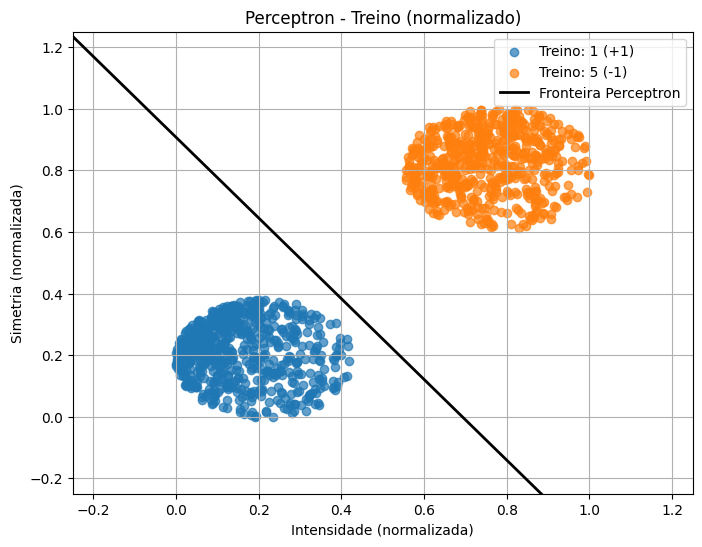

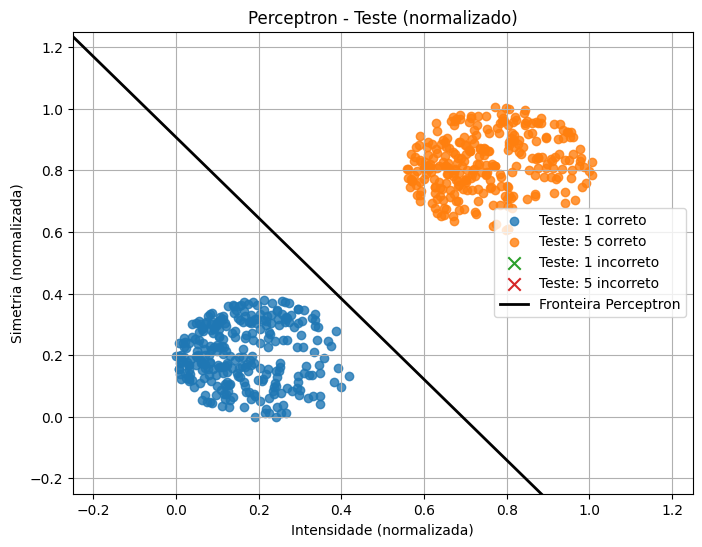

In [45]:
plot_model_results_normalized(perceptron, X_train_1x5, y_train, X_test_1x5, y_test, scaler, "Perceptron")

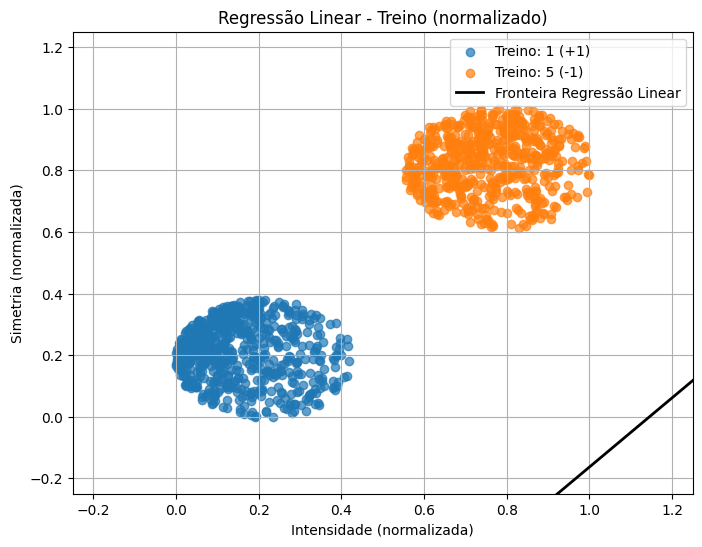

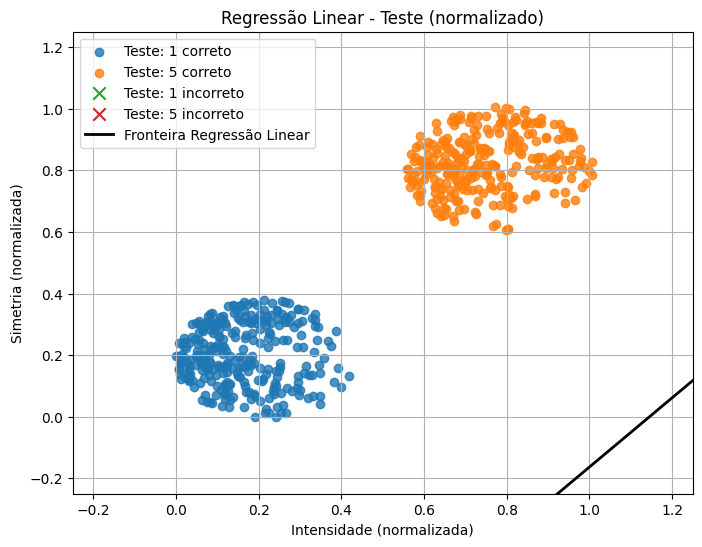

In [46]:
plot_model_results_normalized(linreg, X_train_1x5, y_train, X_test_1x5, y_test, scaler, "Regressão Linear")

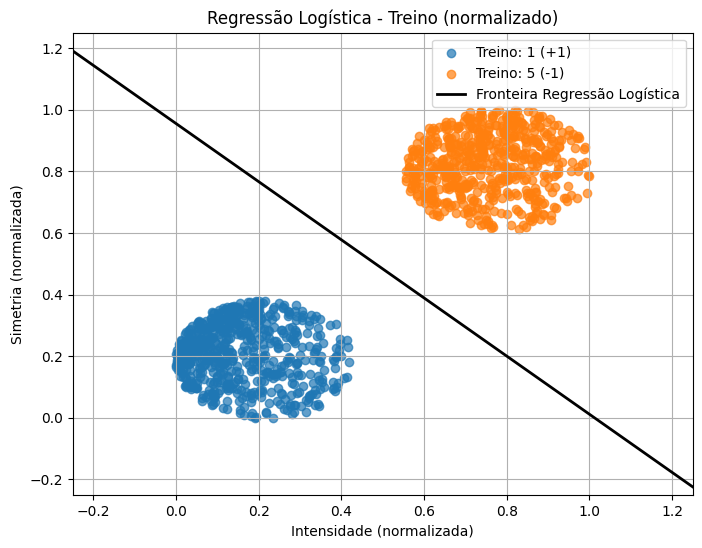

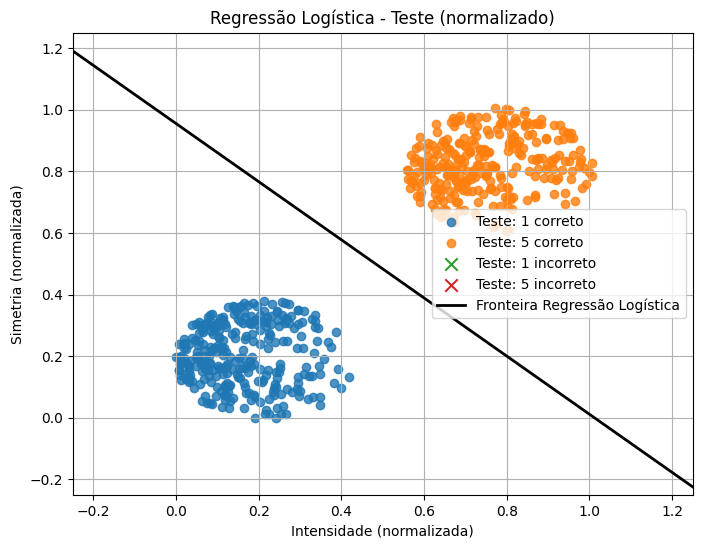

In [47]:
plot_model_results_normalized(logreg, X_train_1x5, y_train, X_test_1x5, y_test, scaler, "Regressão Logística")

## Plotando as três retas para comparação